<a href="https://colab.research.google.com/github/TrunnMosby/GSoC-RedHenLabs-Aztec-Glyph-Detection/blob/main/VGG16_Augmnetedimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import  os
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import base64
from PIL import Image
import io
import math 
from math import sqrt

In [ ]:
base_models=tf.keras.applications.VGG16()

553467904/553467096 [==============================] - 15s 0us/step


In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=base_models.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


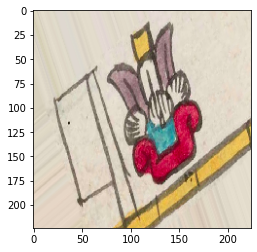

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
predictions = base_models.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted ski with probability 0.541
predicted bow with probability 0.073
predicted matchstick with probability 0.038
predicted rule with probability 0.031
predicted broom with probability 0.020


In [ ]:
base_models.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
feat_extractor = Model(inputs=base_models.input, outputs=base_models.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
_________________________________________________________________


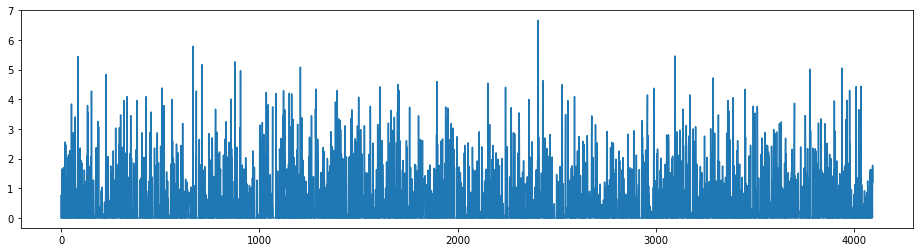

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [ ]:
images_path = '/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images'
image_extensions = ['.jpg', '.png', '.jpeg']   
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 6473 images to analyze


In [ ]:
import time
tic = time.clock()
features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


analyzing image 0 / 6473. Time: 0.0011 seconds.
analyzing image 500 / 6473. Time: 562.1825 seconds.
analyzing image 1000 / 6473. Time: 566.2353 seconds.
analyzing image 1500 / 6473. Time: 558.6177 seconds.
analyzing image 2000 / 6473. Time: 560.4687 seconds.
analyzing image 2500 / 6473. Time: 557.7081 seconds.
analyzing image 3000 / 6473. Time: 557.6395 seconds.
analyzing image 3500 / 6473. Time: 554.7525 seconds.
analyzing image 4000 / 6473. Time: 561.7005 seconds.
analyzing image 4500 / 6473. Time: 558.4157 seconds.
analyzing image 5000 / 6473. Time: 553.5561 seconds.
analyzing image 5500 / 6473. Time: 551.3849 seconds.
analyzing image 6000 / 6473. Time: 554.3614 seconds.
finished extracting features for 6473 images


In [ ]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

[1029, 4467, 1028, 4469, 4466]
Names of the similar images:-
Tlacopan5vSIMPLEX.jpg_0_6465.png
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_991.png
Tlacopan5vSIMPLEX.jpg_0_3898.png
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_6743.png
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_5450.png


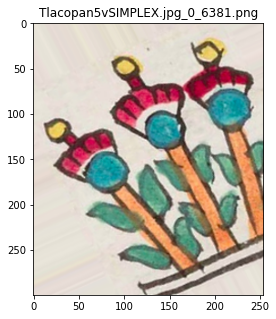

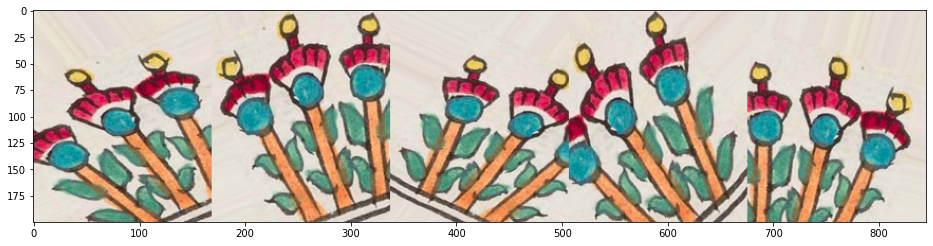

In [ ]:
query_image_idx = 1030
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print(idx_closest)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_5056.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_3795.png
Cillan12rSIMPLEX.jpeg_0_577.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_5026.png
cilin12rsmallshellsSIMPLEXfwithCilan.jpeg_0_9141.png


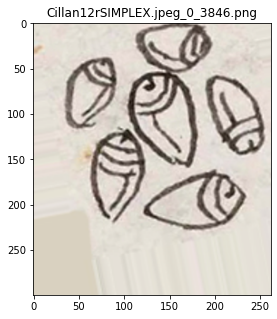

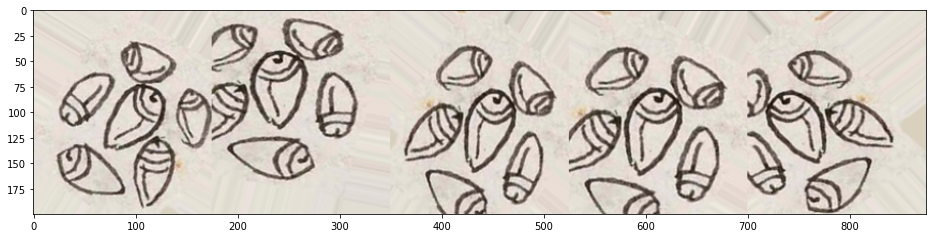

In [ ]:
query_image_idx = 1005
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_5180.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_8111.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_6837.png
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_7586.png
apantli48rwaterchannelFromAhuilizapan.jpg_0_1073.png


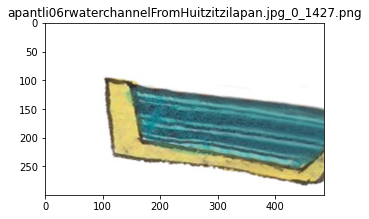

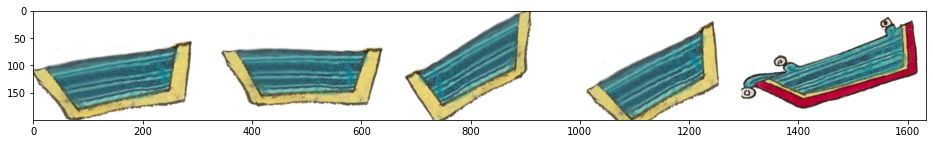

In [ ]:
query_image_idx = 1200
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
Tlapacoyan50r.jpeg_0_650.png
tlapacoyan50rwashingplaceSIMPLEXforTlapacoyan.jpg_0_544.png
Tlapacoyan50r.jpeg_0_9181.png
Tlapacoyan50r.jpeg_0_5405.png
tlapacoyan50rwashingplaceSIMPLEXforTlapacoyan.jpg_0_988.png


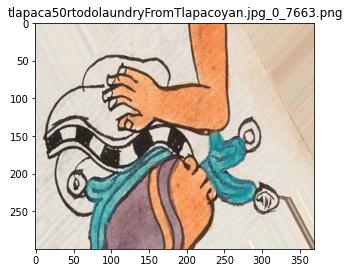

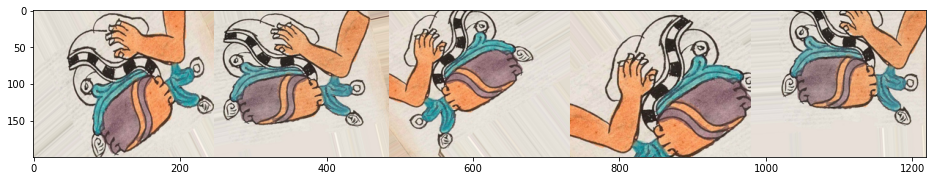

In [ ]:
import random
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
xocotl55rhogplumtreeFromXocoyocan.png_0_2131.png
xocotl55rhogplumtreeFromXocoyocan.png_0_2932.png
xocotl55rhogplumtreeFromXocoyocan.png_0_7145.png
Xocoyocan55r.png_0_9154.png
Xocoyocan55r.png_0_8893.png


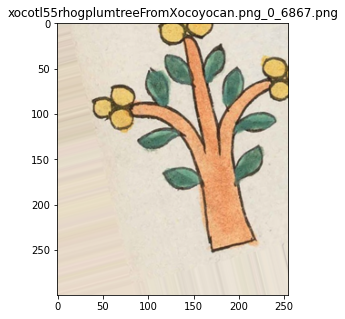

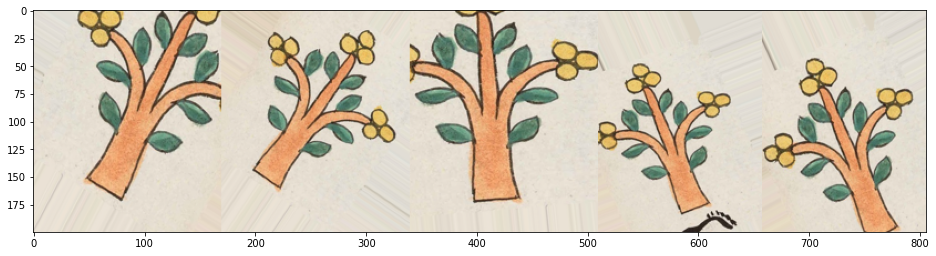

In [ ]:
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])